#### Importing necessary modules:

In [142]:
# These Python modules are necessary for processing the data and also for visualisations.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Study of Wake effect as described by the N. O. Jensen model:

#### N. O. Jensen Single Wake effect model:

##### Defining a Wind Turbine:

In [143]:
class WindTurbine(object):
    def __init__(self, rotor_D, hub_h, Ct, alpha, x, y, V) -> None:
        self.rotor_D = rotor_D # Rotor diameter (m)
        self.hub_h = hub_h # Hub-height (m)
        
        # Position of Turbine in plane: (x +ve downstream)
        self.x = x
        self.y = y

        # Initial undisturbed upstream wind experienced by Turbine blades
        self.V = V
        
        self.Ct = Ct # Coefficient of thrust
        self.alpha = alpha # Linear wake expansion factor

##### The N. O. Jensen Wake Deficit Model:

In [144]:
def jensen_model_deficit(WT: WindTurbine, x_down, ):
    """
    N. O. Jensen model for wake velocity deficit

    Parameters: (vectorized)
    V0 : float
        Free stream wind speed (m/s)
    rotor_D : float
        Rotor diameter of the turbine (m)
    alpha: float
        Wake expansion factor
    x_down : float
        Distance downstream from the turbine (m)
    Ct : float
        Rotor thrust coefficient (m)

    Returns: (vectorized)
    float
        Wake velocity deficit at different distances behind the turbine (m/s)
    """
    V0, Ct, rotor_D, alpha, = WT.V, WT.Ct, WT.rotor_D, WT.alpha,

    rotor_r = rotor_D/2
    wake_r = rotor_r + alpha*x_down

    wake_deficit = np.where(wake_r>=rotor_r,V0*(1-np.sqrt(1-Ct))*np.power(rotor_r/wake_r,2),0) # If 'x_down' is negative 'Wake deficit' is not defined (0)
    return wake_deficit

##### Testing the Single Wake model:

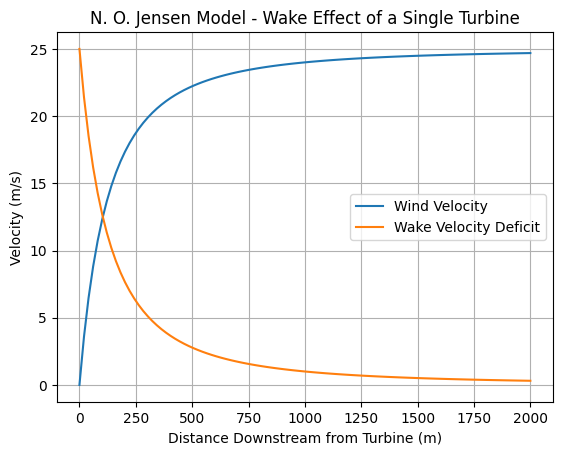

In [131]:
# Parameters:

V = float(input("Free stream wind speed (m/s):")) # Free stream wind speed (m/s)
rotor_D = float(input("Enter rotor diameter(m):"))   # Rotor diameter of the turbine (m)

hub_h = int(input("Hub-height:")) # Hub height of the turbine
z0 = float(input("Surface roughness factor:"))   # Surface roughness coefficient
alpha = 1/(2*np.log(hub_h/z0))
alpha = 0.04 # Common value

Ct = float(input("Enter the thrust coefficient:")) # Thrust coefficient of turbine

# Defining the Wind Turbine
WT = WindTurbine(rotor_D, hub_h, Ct, alpha, 0, 0, V)

# Distance range
x_range = np.linspace(0, 100 * WT.rotor_D, 100)

# Calculate the wake velocity deficit
vel_deficit = jensen_model_deficit(WT, x_range,)
wake_velocity = WT.V - vel_deficit

# Plot the wake velocity and deficit
plt.plot(x_range, wake_velocity, label='Wind Velocity')
plt.plot(x_range, vel_deficit, label='Wake Velocity Deficit')
plt.xlabel('Distance Downstream from Turbine (m)')
plt.ylabel('Velocity (m/s)')
plt.title('N. O. Jensen Model - Wake Effect of a Single Turbine')
plt.legend()
plt.grid()
plt.show()


#### Multiple Wake Effect on a Wind Farm using Superposition Principle:

##### Implementing Multiple Wake Superposition and Area Overlap modelling methods:

In [145]:
def calc_shadow_coeff(WT1:WindTurbine,WT2:WindTurbine):
    """
    Calculate the area of shadow cast on the area swept by turbine WT2, 
    by the Wake circle of the turbine WT1.

    Returns the fractional portion of WT2 area covered.
    """
    
    # As shadow is only cast by upstream turbine on downstream turbine
    if(WT1.x >= WT2.x):
        return 0
    
    dx_12 = WT2.x - WT1.x

    R = WT1.rotor_D/2 + WT1.alpha * dx_12
    r = WT2.rotor_D/2

    R, r = max(R,r), min(R,r)

    dy_12 = np.abs(WT2.y - WT1.y)

    if(dy_12<=np.abs(R-r)): # Full overlap:
        return 1
    
    if(dy_12>=R+r): # No overlap:
        return 0
    
    # Partial overlap:
    h_center = (R + r + dy_12) / 2
    A_tri = np.sqrt((h_center)*(h_center-R)*(h_center-r)*(h_center-dy_12))

    l = 2 * A_tri / dy_12
    cos_theta = (R**2+r**2-dy_12**2)/(2*R*r)
    if (cos_theta>r/R):
        A_shadow = (R**2)*np.arctan(l/R) + (r**2)*(np.pi - np.arctan(l/r)) - 2*A_tri
    else:
        A_shadow = (R**2)*np.arctan(l/R) + (r**2)*(np.arctan(l/r)) - 2*A_tri
    
    # Return the fraction of total area shadowed:
    return A_shadow / (np.pi*((WT2.rotor_D/2)**2))


def calc_WT_vel_superposition(WT:WindTurbine,turbines):
    """
    Calculates and updates the net velocity experienced by turbine WT, 
    from upstream, owing to the cumulative Wake effect of all 
    upstream Wind Turbines, calculated using momentum-conserved superposition.
    """
    total_deficit = 0
    for wt in turbines:
        if(wt.x>WT.x):
            break
        
        beta = calc_shadow_coeff(wt,WT)

        # Very inefficient implementation
        total_deficit += beta*(WT.V**2 - (WT.V - jensen_model_deficit(wt, WT.x-wt.x)*beta)**2)
        
        # print(f"({WT.x,WT.y}) Shadow_coeff: {beta}")
    
    # Updating the effective velocity of oncoming upstream wind, after superposition of Wake effects.
    WT.V = np.sqrt(WT.V**2 - total_deficit)
    
    return

def calc_point_vel_superposition(V,x,y,turbines):
    """
    Calculate the net wind speed at a point in the plane, 
    due to the cumulative effects of all upstream Wakes.

    Parameters:

    x : float
        The x co-ordinate of the point in plane
    y : float
        The y co-ordinate of the point in plane
    V : float
        The undisturbed wind speed at point.
    turbines : array of WindTurbine elements
        The description of all WT's in the farm
    """
    vel_deficit = 0
    for wt in turbines:
        if(wt.x>x):
            break
        if(np.abs(wt.y - y) <= (wt.rotor_D/2 + wt.alpha*(x - wt.x))):
            # Very inefficient implementation
            vel_deficit += (V**2 - (V - jensen_model_deficit(wt, x-wt.x))**2)
     
    res = np.sqrt(V**2 - vel_deficit)

    return res


##### Defining the Power Curve of the Vestas V90 1.8MW Wind Turbine:

In [146]:
def power_out(vel, rated_p=1.8, cut_in_v = 3.5, cut_out_v = 25, rated_v = 20):
    """
    Returns the power output of a WT (mega watts) given upstream wind speed 'vel' (m/s)
    Default values are chosen of the Vestas V90 1.8 MW Wind Turbine
    """
    return np.where(vel>=cut_in_v ,np.where(vel<rated_v ,rated_p*(vel**3-cut_in_v**3)/(rated_v**3-cut_in_v**3),np.where(vel<=cut_out_v,rated_p,0)),0)

##### Defining the Wind Farm layout and Wind Turbine specifications:

In [147]:
# Description of the Wind Farm layout and Turbine specification:

# WT specifications
rotor_D, hub_h, Ct, alpha = 20, 100, 0.3, 0.08

# Wind Farm layout:
V = 15 
theta = 0
seperation  = 6 * rotor_D
rows = 4
columns = 3

# Initializing WT's according to layout and specifications.
turbines = np.empty(shape=(rows,columns),dtype=np.dtype("object"))
for i in range(rows):
    for j in range(columns):

        # # Assigning the position of WT on plane (Grid configuration)
        # x_co = seperation*j
        # y_co = seperation*i
        
        # Another configuration (Alternate Shifted Grid)
        x_co = seperation*j 
        y_co = seperation*i + seperation*(j%2)/2
        
        turbines[i,j] = WindTurbine(rotor_D,hub_h,Ct,alpha,x_co,y_co,V)

turbines = turbines.T.flatten() # Change the layout of the array from 2D to 1D.

##### Defining function for Rotation of Plane and Calculation of Velocity Field:

In [148]:
def rotate_turbine_layout(turbines, theta):
    """
    Rotates the plane of Wind Turbines to align wind direction along +ve x-axis.

    Input:
        'theta': Angle by which plane is rotated w.r.t. +ve x-axis.
        'turbines' : A collection of all Wind Turbines in the farm, each at a particular point in 2D-plane.    
    """
    theta = theta*np.pi/180
    for wt in turbines:
        wt.x, wt.y = (wt.x)*np.cos(theta) - (wt.y)*np.sin(theta) , (wt.x)*np.sin(theta) + (wt.y)*np.cos(theta) 
    
    return np.asarray(sorted(turbines,key=lambda WT: WT.x))

def WF_vel_distribution(turbines):
    # Calculating the upper and lower limits of the plane:
    y_upper = y_lower = 0
    for wt in turbines:
        if(wt.y<y_lower):
            y_lower = wt.y
        if(wt.y>y_upper):
            y_upper = wt.y
    x_lower = turbines[0].x
    x_upper = turbines[rows*columns - 1].x

    # Defining the plane on which wind velocity field will be calculated.
    x_range = np.linspace(x_lower - 10, x_upper + seperation, 200)
    y_range = np.linspace(y_lower - 3*rotor_D, y_upper + 3*rotor_D, 200)

    # Populating the planar space with wind calculated velocities
    def vel_field(turbines,x_range,y_range):
        dist = np.empty(shape=(x_range.size,y_range.size),dtype=np.dtype("float64"))
        for x_i in range(x_range.size):
            for y_i in range(y_range.size):
                dist[x_i,y_i] = calc_point_vel_superposition(V,x_range[x_i],y_range[y_i], turbines)

        return dist.T
    
    return vel_field(turbines,x_range, y_range)


##### Computation of Wake effect and Farm Power Output:

In [149]:
# Test the Wind Farm for different Wind Directions:
velocity_fields = []
wind_angle = []
generated_power = []

step_number = 18
step_angle = 180//step_number

for i in range(step_number):
    # Set the idle wind-velocity faced by each turbine:
    for wt in turbines:
        wt.V = V

    # Calculating Wake effect over the entire Wind Farm:
    for wt in turbines:
        calc_WT_vel_superposition(wt,turbines)    

    total_output = 0
    for wt in turbines:
        total_output += power_out(wt.V)

    velocity_fields.append(WF_vel_distribution(turbines))
    wind_angle.append(theta)
    generated_power.append(total_output)

    # Rotating planar frame, to adjust wind direction:
    turbines = rotate_turbine_layout(turbines,-(step_angle)) # Rotation of wind direction along +ve x-axis, hence opposite(-) rotation aligns layout.

    theta = (theta + step_angle)%360

    # for wt in angled_turbines:
    #     print(f"Position:({wt.x},{wt.y}) Velocity: {wt.V} m/s")



##### Visualising the Wind Velocity Fields for different Wind Conditions:

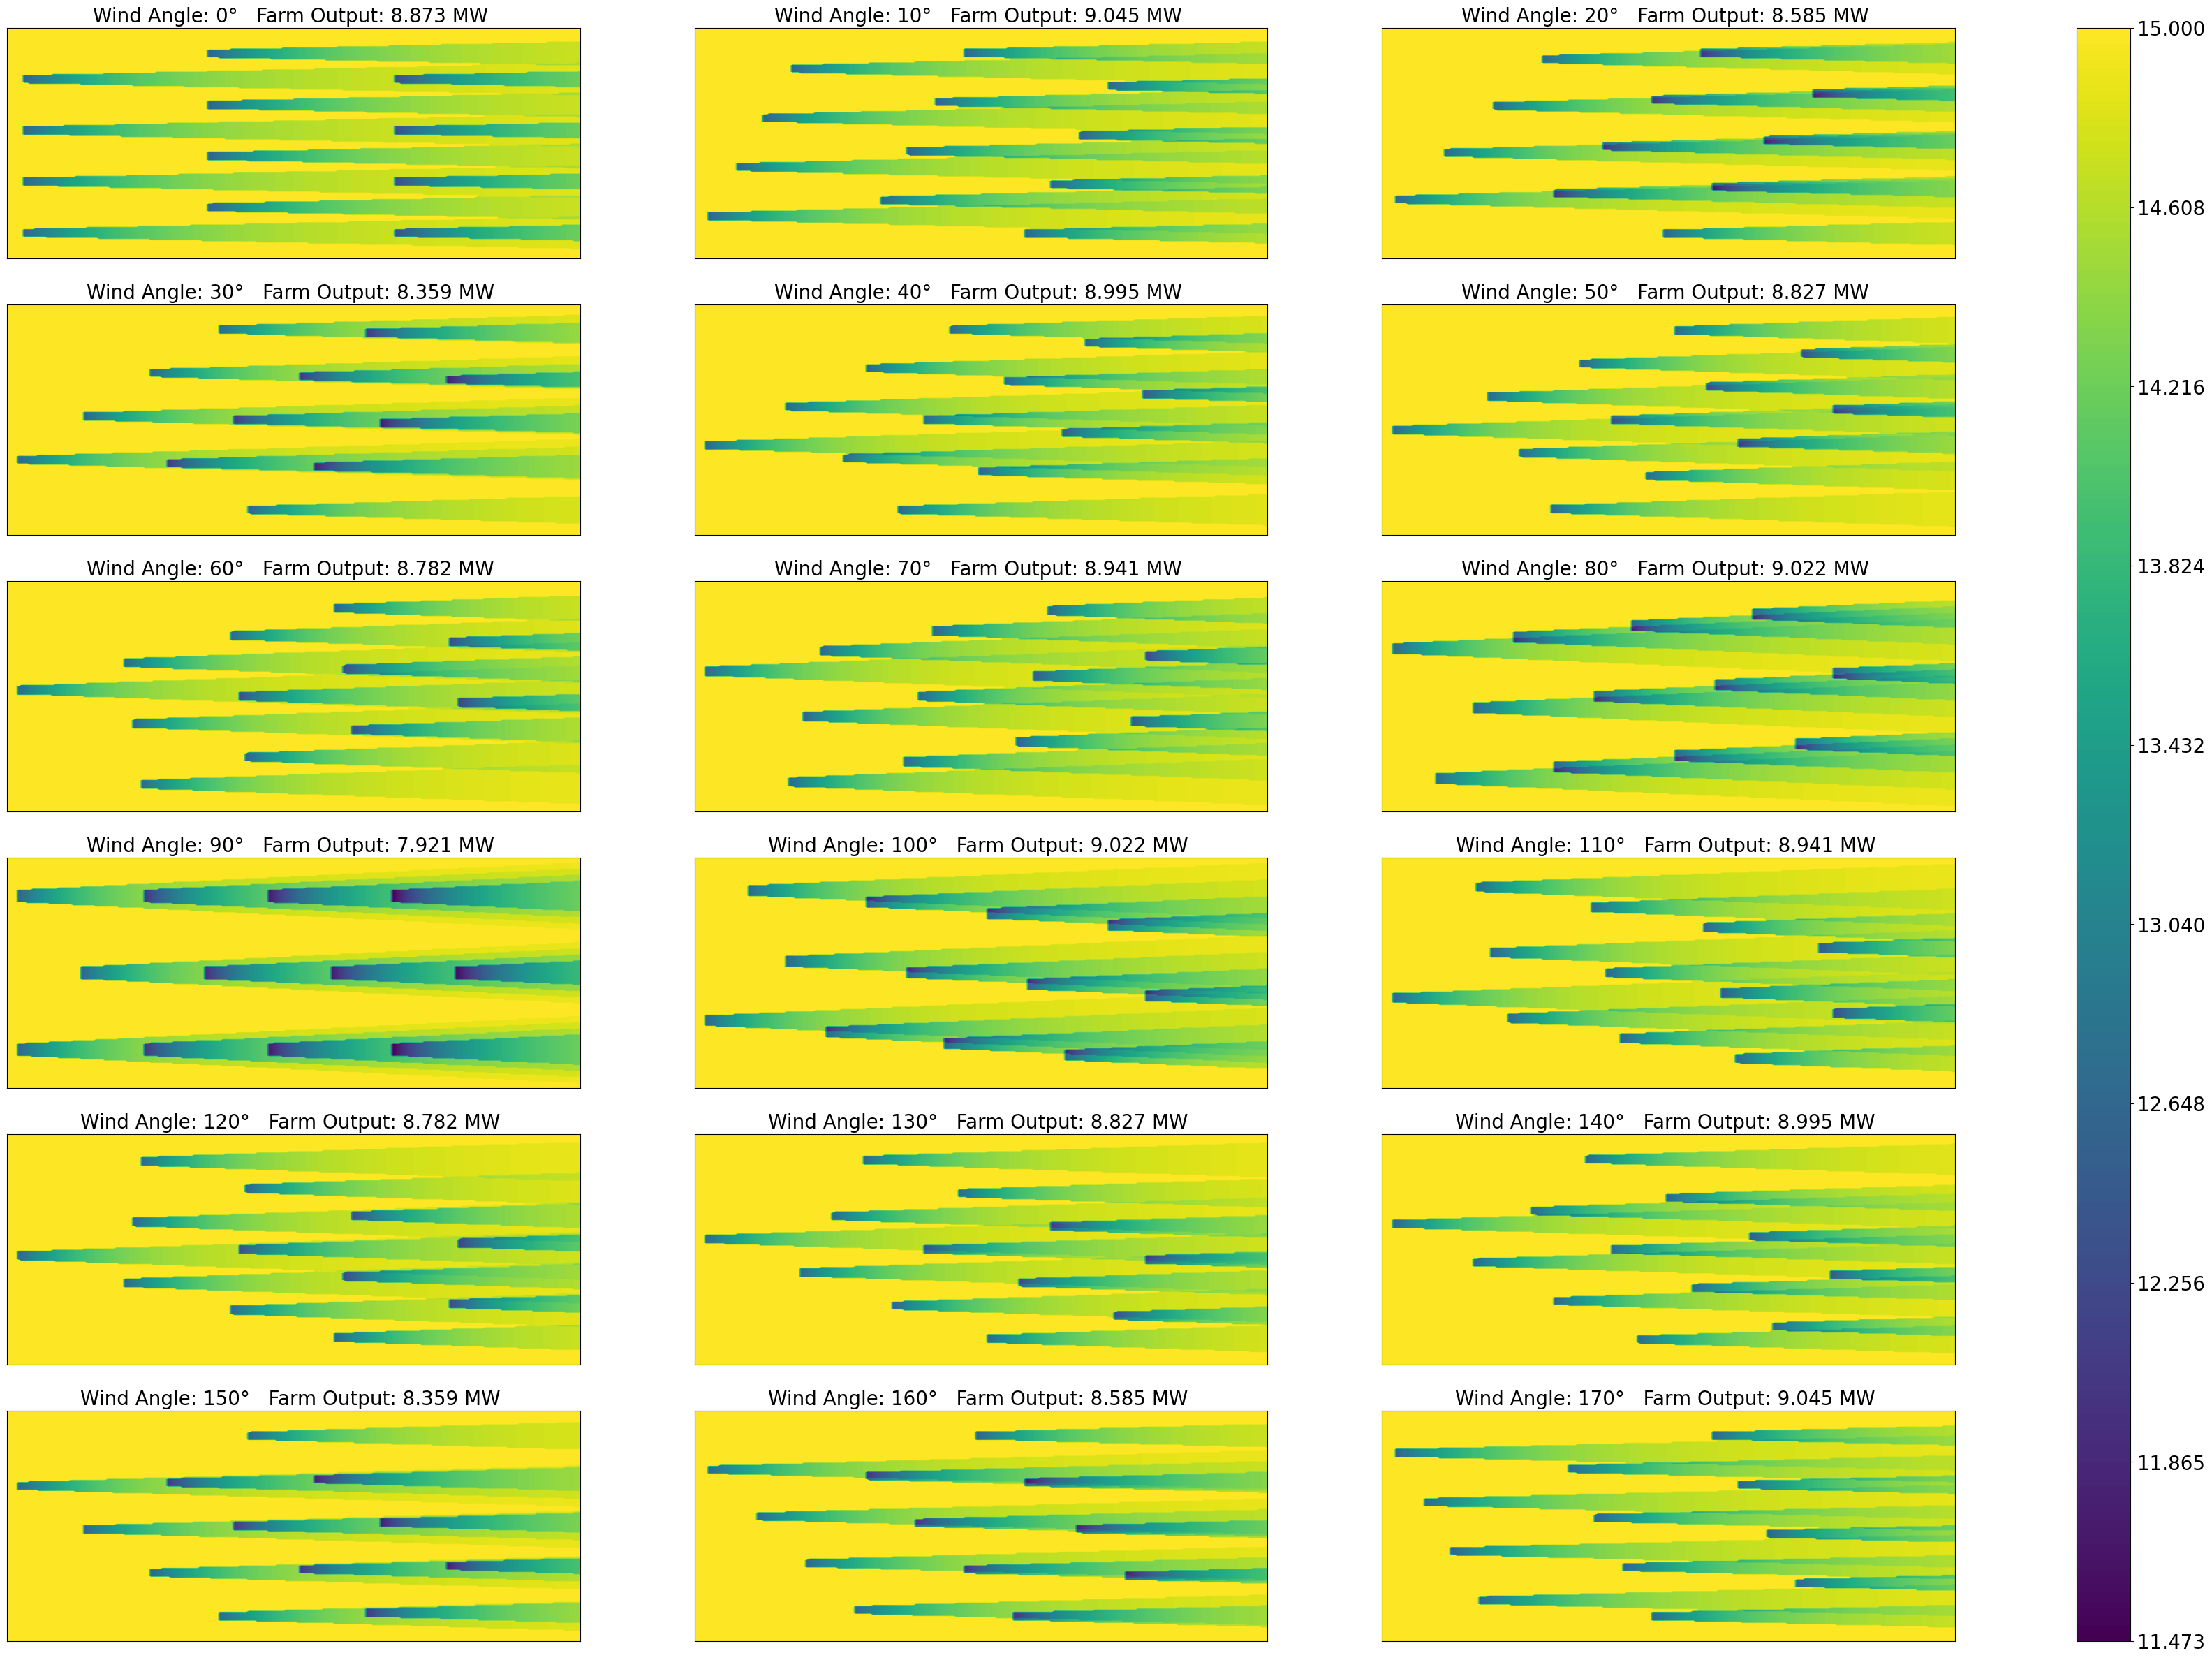

In [151]:
def plot_contous(velocity_fields,rotations,power_outs):
    """
    Plot contour plots for each 2D matrix in a given list of velocity_fields.
    The whole figure will have a single colorbar for all plots with uniform color coding based on the minimum and maximum values across all velocity_fields.

    Parameters:
    velocity_fields (list of 2D arrays): A list of 2D velocity_fields (numpy arrays) to be plotted.

    rotations : A list of angles by which the plane is rotated.

    Returns:
    None
    """

    # Calculate the minimum and maximum values across all velocity_fields
    min_val = min(np.min(matrix) for matrix in velocity_fields)
    max_val = max(np.max(matrix) for matrix in velocity_fields)

    num_velocity_fields = len(velocity_fields)
    num_rows = (num_velocity_fields + 2) // 3  # Number of rows in the figure
    num_cols = min(3 , num_velocity_fields)  # Number of columns in the figure

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15*num_cols, 5*num_rows))

    contour_plots = []  # List to store contour plots for all velocity_fields

    for i, matrix in enumerate(velocity_fields):
        if num_velocity_fields > 1:
            ax = axes[i // num_cols, i % num_cols]
        else:
            ax = axes  # For a single matrix, use the same axis

        # Create a contour plot for the current matrix with uniform color coding
        contour = ax.contourf(matrix, levels=np.linspace(min_val, max_val, 200))

        # Set plot title and labels
        ax.set_title(f"Wind Angle: {rotations[i]}°   Farm Output: {'{:.3f}'.format(power_outs[i])} MW ",fontsize=20)
        # ax.set_xlabel("X-axis")
        # ax.set_ylabel("Y-axis")

        # Remove x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
        contour_plots.append(contour)

    # Get the maximum number of contour levels among all plots for the colorbar
    # num_levels = max(len(c.levels) for c in contour_plots)

    # Create a single horizontal colorbar for all contour plots with the same number of levels
    cbar = fig.colorbar(contour_plots[0], ax=axes, ticks=np.linspace(min_val, max_val, 10), orientation='vertical',aspect=30)

    # Set the fontsize of the color bar labels
    cbar.ax.tick_params(labelsize=20)

    # Add a title for the entire figure
    # plt.suptitle("Directed Wind Velocity Distributions", fontsize=16)
    
    plt.show()

# Display the results:
plot_contous(velocity_fields,wind_angle,generated_power)

#### Power output calculations and characteristic curves:

##### Importing and organising the Wind and Power Output data:

In [4]:
path = ".\wind_data.txt"

windpower_data = pd.read_csv(path,sep='\t')
windpower_data.head()

,Date(YYYY-MM-DD hh:mm:ss),W,P
0,01-01-2006 00:00,5.12,1.788
1,01-01-2006 00:10,5.12,1.788
2,01-01-2006 00:20,5.14,1.812
3,01-01-2006 00:30,5.17,1.848
4,01-01-2006 00:40,5.24,1.929


In [5]:
windpower_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date(YYYY-MM-DD hh:mm:ss)  52560 non-null  object 
 1   W                          52560 non-null  float64
 2   P                          52560 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.2+ MB


In [6]:
date_format = "%d-%m-%Y %H:%M"
windpower_data["Date(YYYY-MM-DD hh:mm:ss)"] = pd.to_datetime(windpower_data["Date(YYYY-MM-DD hh:mm:ss)"],format=date_format)
# windpower_data["P"] = windpower_data["P"] / 100 # Converting to MW

In [7]:
windpower_data.set_index("Date(YYYY-MM-DD hh:mm:ss)",inplace=True)
windpower_data.rename_axis(index=[None, ],inplace=True)
windpower_data.rename(columns={"W":"Wind Speed (m/s)", "P":"Actual Power Output", },inplace=True)

In [8]:
windpower_data.head()

,Wind Speed (m/s),Actual Power Output (MW)
2006-01-01 00:00:00,5.12,1.788
2006-01-01 00:10:00,5.12,1.788
2006-01-01 00:20:00,5.14,1.812
2006-01-01 00:30:00,5.17,1.848
2006-01-01 00:40:00,5.24,1.929


##### Using the previously defined Power Curve to Calculate Output:

In [10]:
# Calculating the theoretical power output at different wind speeds:
windpower_data["Theoretical Power Output (MW)"] = power_out(windpower_data["Wind Speed (m/s)"])
windpower_data.head()

,Wind Speed (m/s),Actual Power Output (MW),Theoretical Power Output (MW)
2006-01-01 00:00:00,5.12,1.788,0.020663
2006-01-01 00:10:00,5.12,1.788,0.020663
2006-01-01 00:20:00,5.14,1.812,0.021020
2006-01-01 00:30:00,5.17,1.848,0.021561
2006-01-01 00:40:00,5.24,1.929,0.022848


##### Visualising the Offshore Wind Speed data:

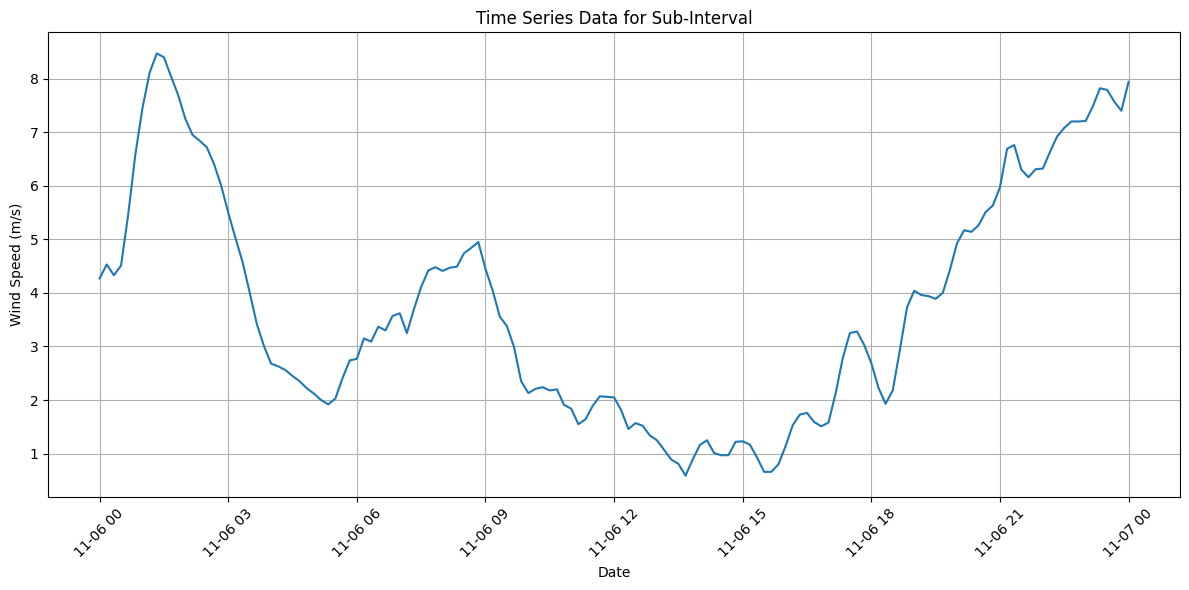

In [11]:
# The wind speed data over a period of time visualised:
plt.figure(figsize=(12, 6))

start_date = '2006-11-06 00:00'
end_date = '2006-11-07 00:00'
data_subinterval = windpower_data.loc[start_date:end_date]

# plt.plot(data_subinterval.index, data_subinterval['P'], marker='.', linestyle='-')
plt.plot(data_subinterval.index, data_subinterval['Wind Speed (m/s)'])

plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Time Series Data for Sub-Interval')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Visualising the Power Curves from given Wind Speed data:

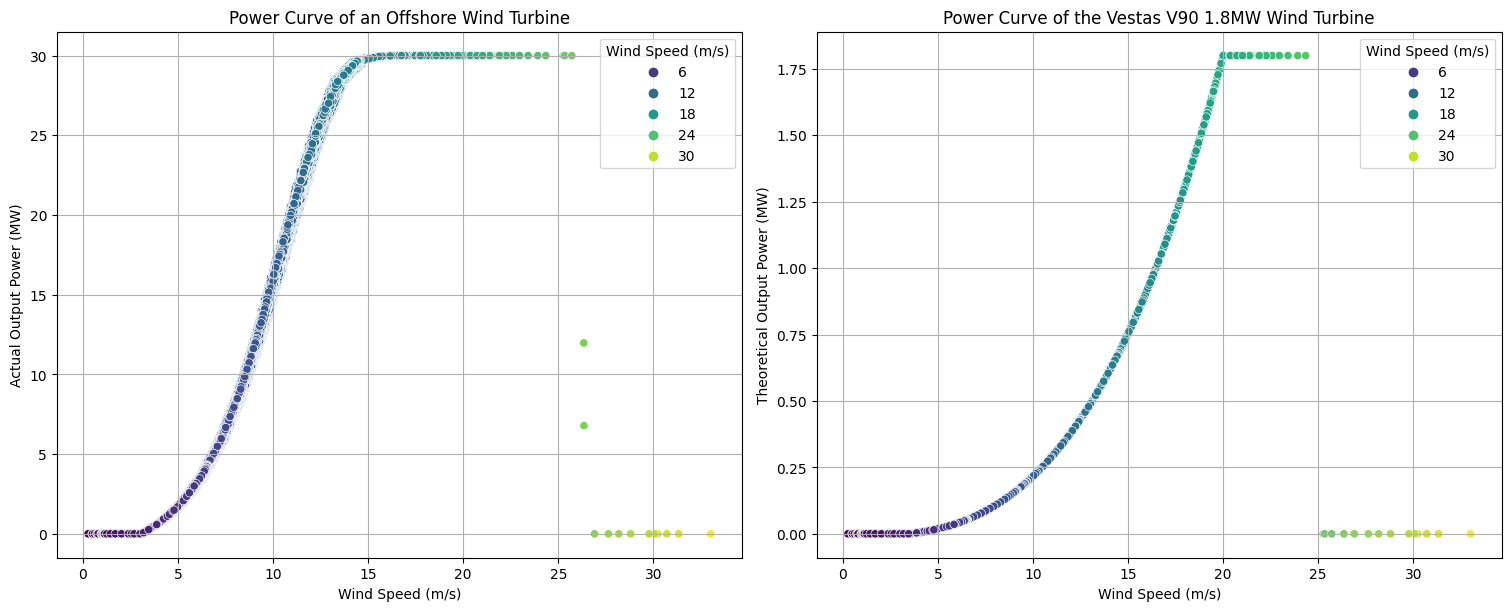

In [12]:
# The Power Curve (Output Power v.s. Wind Speed characteristics)

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,6),layout="constrained")

sns.scatterplot(windpower_data,x="Wind Speed (m/s)",y="Actual Power Output",hue="Wind Speed (m/s)",palette=sns.color_palette("viridis",as_cmap=True),ax=axs[0])

axs[0].grid()
axs[0].set_ylabel('Actual Output Power')
axs[0].set_xlabel('Wind Speed (m/s)')
# axs[0].set_facecolor("grey")
axs[0].set_title('Power Curve of an Offshore Wind Turbine')

sns.scatterplot(windpower_data,x="Wind Speed (m/s)",y="Theoretical Power Output (MW)",hue="Wind Speed (m/s)",palette=sns.color_palette("viridis",as_cmap=True),ax=axs[1])

axs[1].grid()
axs[1].set_ylabel('Theoretical Output Power (MW)')
axs[1].set_xlabel('Wind Speed (m/s)')
# axs[1].set_facecolor("grey")
axs[1].set_title('Power Curve of the Vestas V90 1.8MW Wind Turbine')

plt.show()

##### Visualising the Variation of Farm Output with Wind Direction:

In [163]:
deg_res = 0.1
output_curve = []

theta = 0
for i in range(int(360/deg_res)):
    # Set the idle wind-velocity faced by each turbine:
    for wt in turbines:
        wt.V = V

    # Calculating Wake effect over the entire Wind Farm:
    for wt in turbines:
        calc_WT_vel_superposition(wt,turbines)    

    total_output = 0
    for wt in turbines:
        total_output += power_out(wt.V)

    output_curve.append((theta, total_output))

    # Rotating planar frame, to adjust wind direction:
    turbines = rotate_turbine_layout(turbines,-(deg_res)) # Rotation of wind direction along +ve x-axis, hence opposite(-) rotation aligns layout.

    theta = (theta + deg_res)%360


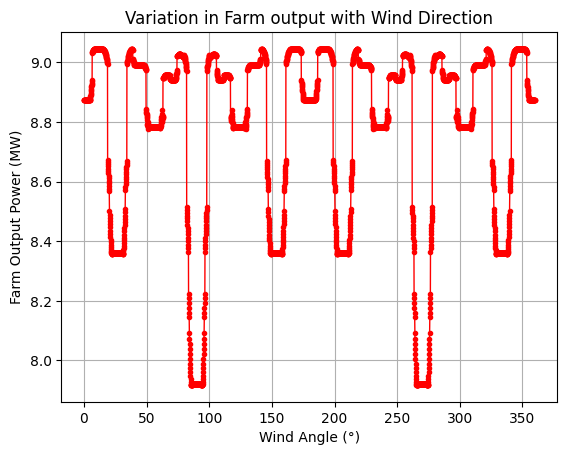

In [164]:
def plot_points(points):
    """
    Plot a list of points on a 2D coordinate plane.

    Parameters:
    points (list of tuples): A list of points in the form of (x, y) tuples.

    Returns:
    None
    """
    # Extract x and y coordinates from the list of points
    x_coords, y_coords = zip(*points)

    # # Create the plot
    # plt.scatter(x_coords, y_coords, marker='.', color='blue',)

    # Create the plot with scatter points
    plt.plot(x_coords, y_coords, color='red', marker='.', linestyle='-', linewidth=1)

    plt.xlabel("Wind Angle (°)")
    plt.ylabel("Farm Output Power (MW)")
    plt.title('Variation in Farm output with Wind Direction')
    plt.grid(True)

    # Show the plot
    plt.show()

plot_points(output_curve)